In [2]:
#https://amitrajitbose.github.io/blog/hiding-input-cells-jupyter-notebook/
# This is a cell to hide code snippets from displaying
# This must be at first cell!

from IPython.display import HTML

hide_me = ''
HTML('''<script>                                    |
code_show=true; 
function code_toggle() {
  if (code_show) {
    $('div.input').each(function(id) {
      el = $(this).find('.cm-variable:first');
      if (id == 0 || el.text() == 'hide_me') {
        $(this).hide();
      }
    });
    $('div.output_prompt').css('opacity', 0);
  } else {
    $('div.input').each(function(id) {
      $(this).show();
    });
    $('div.output_prompt').css('opacity', 1);
  }
  code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input style="opacity:0" type="submit" value="Click here to toggle on/off the raw code."></form>''')


# Imports

In [3]:
#%matplotlib notebook
#para que funcione voila
%matplotlib ipympl
import os
from datetime import datetime
from IPython.display import display, HTML
import ipywidgets as widgets


from pathlib import Path  #to get user directory
from IPython.display import clear_output
#importa las fuciones que cree desde otro notebook (instalar modulo ipynb)
import ipynb.fs.full.my_funcs_clusters as myfunc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import font_manager
import matplotlib.dates as mdates #para poner meses en las ticks
from matplotlib import image
import matplotlib
#matplotlib.use('nbAgg')
#valores despues del punto decimal
pd.set_option("display.precision", 4)

In [4]:
import importlib
importlib.reload(myfunc);

# Procesamiento de datos e información general

In [5]:
data_path ='datos/DP-PB01-2005.xlsx'
mf_pow_curve_path ='datos/DeWind d8.2.csv'
df_wind_dir, df_comp_vel,df_mf_curve = myfunc.proc_dat_bcs(data_path,mf_pow_curve_path)


Inciando procesamiento de datos...

Total de registros: 52560
Numero de filas sin datos
day      0.0
hour     0.0
wdir     0.0
vwind    0.0
dtype: float64
Fin del procesamiento de datos


In [6]:
'''
Se reemplaza la hora 24:00 por 00:00 y se suma un día, así que la última
toma de datos de un día se cambia por la primera del día siguiente
'''
def proc_dat_bcs(data_path,mf_pow_curve_path=None):
    """
    Procesamiento de datos de BCS, viento y curva del fabricante.
    :param data_path: ruta del archivo de los datos de viento
    :param mf_pow_curve_path:
    :return:
    """
    ###########################################configuración
    columns_to_use = [0,1,3,6]
    columns_id =['day','hour','wdir','vwind']
    dir_format= 'deg'
    year = '2005' #data year
    ########################################################
    #imprimir a consola
    os.write(1, b"Inciando procesamiento de datos...\n")
    print("Inciando procesamiento de datos...\n")
    dataVDxls = pd.read_excel(data_path,usecols=columns_to_use,dtype={'DIA' : str, 'HORA':str})
    dataVDxls.columns =columns_id
    #agrego la columna de potencia instantanea sin filtrar
    #dataVPxls['Pw']= (dataVPxls.iloc[1:,1].values-dataVPxls.iloc[0:-1,1]) * np.pi*45**2
    print('Total de registros: ' + str(len(dataVDxls)))

    #marcando los datos faltantes asignando un nan a la fila completa
    datamk = dataVDxls
    datamk.loc[datamk.isnull().any(axis=1), :] = np.nan
    #numero de filas sin datos
    print('Numero de filas sin datos')
    print(datamk.loc[datamk.isnull().any(axis=1), :].isnull().sum())

    #eliminando filas con NaN
    cleanData = datamk.dropna()


    #datos direccion velocidad
    #print(len(dataVP))
    #print(len(dataDir))
    #dataDV = pd.concat([dataDir,dataVP.vViento],axis=1)
    #dataVD = pd.concat([dataVP.vViento,dataDir,axis=1)
    #dataVcD =pd.concat([dataDir,df_comp_vel],axis=1)
    #change hour 24:00 to 00:00
    dataVDxls['hour']=dataVDxls['hour'].str.replace('2400','0000')
    dataVDxls['timeStamp']= dataVDxls.apply(lambda x: daymin2date(year,x.day, x.hour), axis=1)
    #cambiar formato de 24:00 a 00:00 sumando un día a 00:00
    filtro1 = dataVDxls['timeStamp'].dt.hour==0
    filtro2 = dataVDxls['timeStamp'].dt.minute==0
    idx =np.where(filtro1.values & filtro2.values)
    ts = dataVDxls['timeStamp'].values
    ts[idx]=ts[idx] + pd.to_timedelta(1,'d')
    dataVDxls['timeStamp'] = ts
    dataVDxls.set_index('timeStamp',inplace=True,verify_integrity = True)
    dfWD = dataVDxls.drop(columns=['day','hour'])
    dfWD.index = pd.to_datetime(pd.to_datetime(dfWD.index).strftime('%d/%m/%Y %H:%M'))

    del dataVDxls
    #CHECK THE DIRECTION OF THE ANEMOMETER
    if dir_format == 'rad':
        direcvrad= np.deg2rad(dfWD['wdir'].values)
        vecVel = [-np.sin(direcvrad)*dfWD['vwind'].values,np.cos(direcvrad)*dfWD['vwind'].values]
    else:
        vecVel = [-np.sin(dfWD['wdir'].values * np.pi / 180) * dfWD['vwind'].values,
                  np.cos(dfWD['wdir'].values * np.pi / 180)* dfWD['vwind'].values]


    vecVelnp = np.array(vecVel).transpose()
    #original sin timestamp
    #df_comp_vel = pd.DataFrame(data=vecVelnp,columns=['vx','vy']
    #con timestamp
    df_comp_vel = pd.DataFrame(data=vecVelnp,columns=['vx','vy'],index=dfWD.index)

    #CURVA DEL FABRICANTE
    if mf_pow_curve_path is not None:
        if mf_pow_curve_path[-3:] == 'csv':
            dfMfgCurve = pd.read_csv(mf_pow_curve_path)
        else:
            dfMfgCurve = pd.read_excel(mf_pow_curve_path,usecols=[0,2],index_col=0)
        dfMfgCurve.set_index('vel',inplace=True)
        os.write(1, b"Fin del procesamiento de datos\n")
        print('Fin del procesamiento de datos')
        return dfWD,df_comp_vel,dfMfgCurve

    else:
        os.write(1, b"Fin del procesamiento de datos\n")
        print('Fin del procesamiento de datos')
        return dfWD,df_comp_vel
#####################


## Serie de tiempo
La gráfica que muestra las variaciones de velocidad de viento a lo largo del tiempo es llamada serie de tiempo. La
serie de tiempo que corresponde a los datos registrados en el año 2005 en baja california se muestran en la Figura 1.

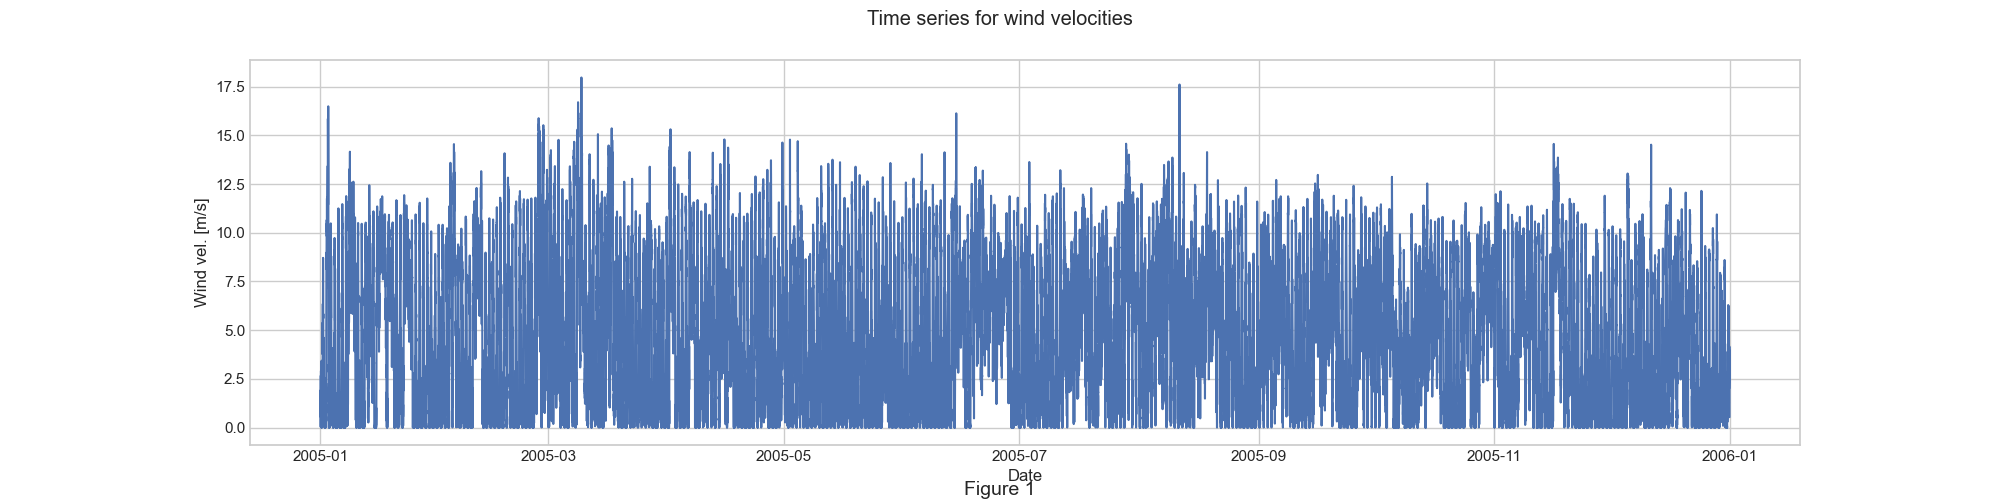

In [7]:
plt.figure(1,figsize=(20,5))
plt.suptitle('Time series for wind velocities')
plt.plot(df_wind_dir.index, df_wind_dir.vwind)
plt.figtext(0.5, 0.01, 'Figure '+ str(plt.gcf().number), wrap=True, horizontalalignment='center', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Wind vel. [m/s]')
plt.show()

# Componentes de velocidad
Los vectores de velocidad de viento se pueden descomponer en sus componentes horizontales y verticales. Si gráficamos
estos componentes, obtenemos un gráfico similar al llamado espacio de fases en mecánica estadística. El espacio de
fases contiene todos los posibles estados y las regiones donde los ponemos encontrar. Fuera de estas regiones no
puede existir ningún estado. En este mismo sentido, podemos definir un "estado de viento" como una región dentro del
espacio de estados que comparte características de velocidad de viento y dirección similares.

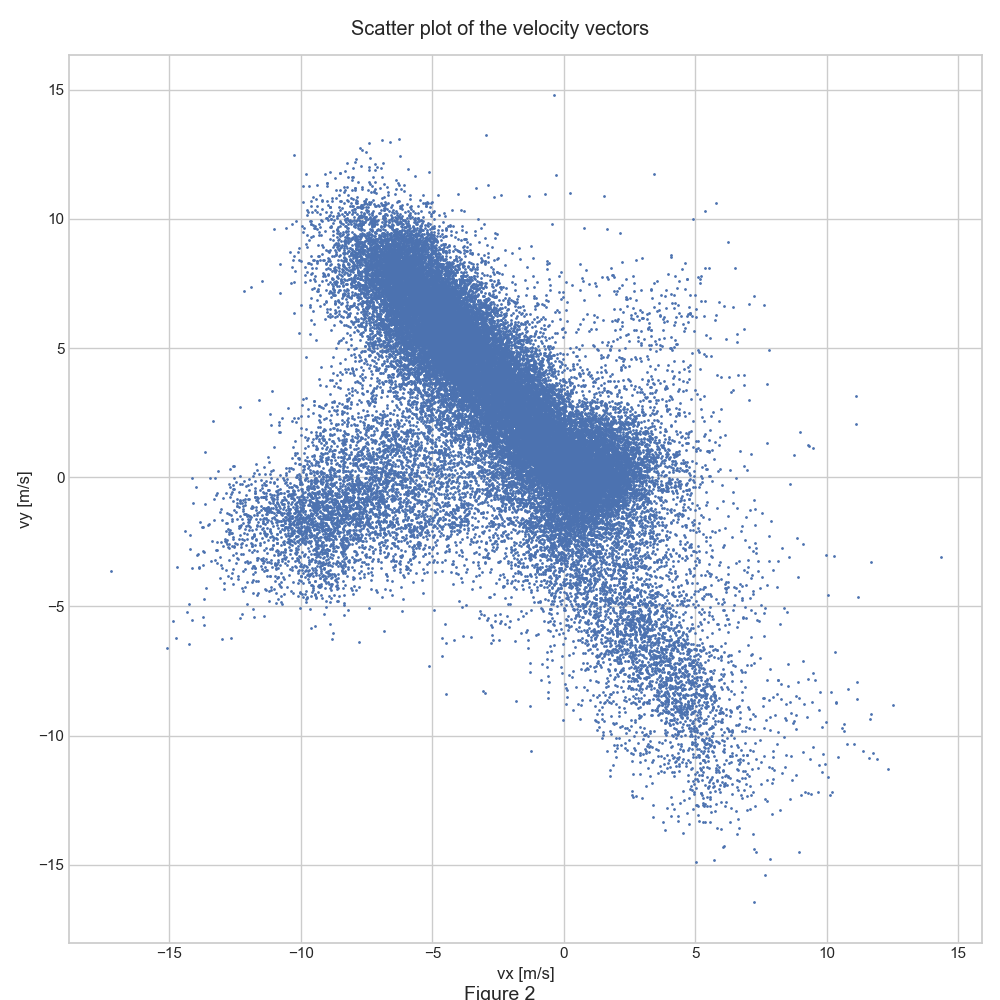

In [8]:
plt.figure(2,figsize=(10,10))
plt.suptitle('Scatter plot of the velocity vectors')
plt.scatter(df_comp_vel.vx,df_comp_vel.vy,s=1)
plt.xlabel('vx [m/s]')
plt.ylabel('vy [m/s]')
plt.tight_layout()
plt.figtext(0.5, 0.0, 'Figure '+ str(plt.gcf().number), wrap=True, horizontalalignment='center', fontsize=14)
plt.show()


# Histograma y density plot
Una forma de encontrar los estados en el espacio de fases, es observando el plot de densidades y el histograma de
frecuencia de los componentes de velocidad. En la Figure 3 podemos observar 5 regiones en el espacio de fases que
podemos clasificar como estados de viento.

C:\Users\mungu\AppData\Local\Temp\ipykernel_30740\31422907.py:81: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  k = kde.gaussian_kde(data.T)
C:\Users\mungu\AppData\Local\Temp\ipykernel_30740\31422907.py:127: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


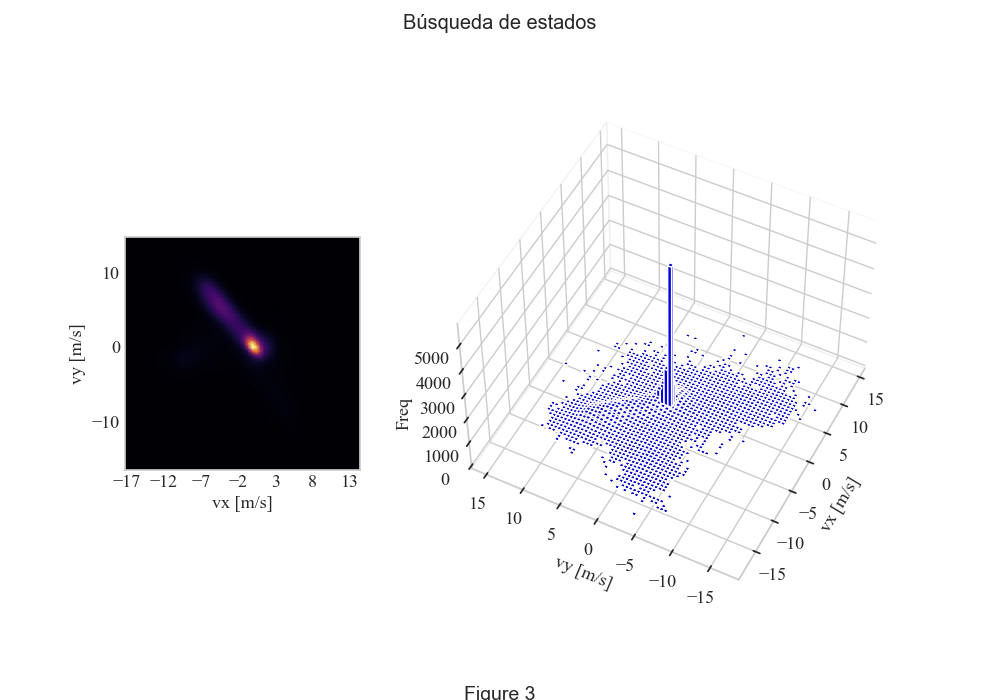

In [9]:
fontsize = 13
labelFontSize = 13
tickFontSize = 12
markerSize = 100
fontNameLabel = {'fontname':'Times New Roman'}
fontNameCluster = {'fontname':'Arial'}
ticks_font = font_manager.FontProperties(family='Times New Roman', style='normal',
                                         size=labelFontSize, weight='normal', stretch='normal')
ticks_font = font_manager.FontProperties(family='Times New Roman', style='normal',
                                         size=labelFontSize, weight='normal', stretch='normal')
#en esta celda se usa gridspec para cambiar el tamaño de subplots individuales
from scipy.stats import kde

pltfstitle =10 #tamaño de fuente
pltfslbl =13
nbins =60

H, xedges, yedges = np.histogram2d(df_comp_vel.vx.values, df_comp_vel.vy.values,bins=nbins )
H=H.T;
#
# Create an X-Y mesh of the same dimension as the 2D data. You can
# think of this as the floor of the plot.
#

x_data, y_data = np.meshgrid( xedges[:-1],yedges[:-1])
# Flatten out the arrays so that they may be passed to "ax.bar3d".
# Basically, ax.bar3d expects three one-dimensional arrays:
# x_data, y_data, z_data. The following call boils down to picking
# one entry from each array and plotting a bar to from
# (x_data[i], y_data[i], 0) to (x_data[i], y_data[i], z_data[i]).
#
x_data = x_data.flatten()
y_data = y_data.flatten()
z_data = H.flatten()

# Create a figure for plotting the data as a 3D histogram.
#
fig = plt.figure(figsize=(10,7))

# eliminar elementos con frecuencia zero
a = z_data[z_data != 0]
idx=np.where(z_data == 0)[0]
b=np.delete(x_data,idx)
c=np.delete(y_data,idx)
z_data=a
x_data=b
y_data=c

# tres graficas
#cmap del histograma2d. Es un array de nx 4 elementos (rgba)
#histograma 3d
#ax = fig.add_subplot(121, projection='3d')
#grid = plt.GridSpec(2,2, wspace=0.3, hspace=0.1)
#axScatter=fig.add_subplot(grid[0, 0])
#axDensity= fig.add_subplot(grid[0, 1])
#axHist2d =fig.add_subplot(grid[1,0: ], projection='3d')

# dos graficas
#cmap del histograma2d. Es un array de nx 4 elementos (rgba)
#histograma 3d
#ax = fig.add_subplot(121, projection='3d')
grid = plt.GridSpec(1, 2, width_ratios=[1, 2])

#grid = plt.GridSpec(1,2, wspace=0.3, hspace=0.1)
#axScatter=fig.add_subplot(grid[0, 0])
axDensity= fig.add_subplot(grid[0, 0])
axHist2d =fig.add_subplot(grid[0,1 ], projection='3d')

#SCATTER
#axScatter.scatter(df_comp_vel.vx,df_comp_vel.vy,s=0.6)
#axScatter.set_ylabel('vy [m/s]', fontsize = pltfslbl)
#axScatter.set_xlabel('vx [m/s]', fontsize = pltfslbl)
##axScatter.set_aspect('equal')
#axScatter.set_xticks(np.arange(np.around(df_comp_vel.vx.min()),df_comp_vel.vx.max(),5))

#DENSITY PLOT

data = np.array(df_comp_vel.values.tolist())
x, y = data.T
# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
k = kde.gaussian_kde(data.T)
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

axDensity.set_ylabel('vy [m/s]', fontsize = pltfslbl,fontname='Times New Roman')
axDensity.set_xlabel('vx [m/s]', fontsize = pltfslbl,fontname='Times New Roman')
axDensity.tick_params(axis='both', labelsize = pltfslbl)
axDensity.set_aspect('equal')
axDensity.set_xticks(np.arange(np.around(df_comp_vel.vx.min()),df_comp_vel.vx.max(),5))


#guardo el objeto pcolormesh para obtener su cmap
axDensity.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap=plt.cm.inferno)

#HIST2D
axHist2d.tick_params(axis='both', labelsize = pltfslbl)
ancho_barra =0.5
largo_barra = 0.5
axHist2d.bar3d( x_data,
                y_data,
                np.zeros_like(z_data),
                ancho_barra, largo_barra, z_data, shade=True,
                color = 'blue')
axHist2d.xaxis.pane.fill = False
axHist2d.yaxis.pane.fill = False
axHist2d.zaxis.pane.fill = False
axHist2d.set_aspect('auto')

#Vista del histograma 3d
axHist2d.view_init(50,-153)
axHist2d.set_ylabel('vy [m/s]', fontsize = pltfslbl,fontname='Times New Roman')
axHist2d.set_xlabel('vx [m/s]', fontsize = pltfslbl,fontname='Times New Roman')
axHist2d.set_zlabel('Freq', fontsize = pltfslbl, rotation= 90,fontname='Times New Roman')

for label in axDensity.get_xticklabels():
    label.set_fontproperties(ticks_font)
for label in axDensity.get_yticklabels():
    label.set_fontproperties(ticks_font)

for label in axHist2d.get_xticklabels():
    label.set_fontproperties(ticks_font)
for label in axHist2d.get_yticklabels():
    label.set_fontproperties(ticks_font)
for label in axHist2d.get_zticklabels():
    label.set_fontproperties(ticks_font)

plt.tight_layout()




#figsavetime = datetime.datetime.now().strftime("%d-%m-%Y_%H_%M_%S_%f")
#plt.savefig('fig_art/pdf_hist2d_'+ figsavetime +'.png', bbox_inches='tight', pad_inches=0.1)

plt.suptitle('Búsqueda de estados')
plt.figtext(0.5, 0.0, 'Figure '+ str(plt.gcf().number), wrap=True, horizontalalignment='center', fontsize=14)

plt.show()

# Clusters
Ya que tenemos identificados los estados, los encontramos usando un método de agrupamiento llamado k-means. EL método
k-means encuentra puntos en los datos que funcionaran como ancla para definir que puntos se encuentran dentro de
determinado grupo mediante distancias euclidianas y el algoritmo de <i> maximum-likelihood</i>. Se eligieron
empíricamente 15 grupos, los cuales corresponden a 15 estados dentro del espacio de fases. La gráfica con los 15
estados de viento dentro del espacio de fases se muestra en la Figure 4.

In [24]:
n_clusters = 15
clusters_wind = myfunc.KMData()
clusters_wind.dataframe_to_cluster(df_comp_vel, n_clusters=n_clusters, clusters_data='wind')
#crear un dataframe viento, direccion, cluster
df_wind_dir_cl = df_wind_dir.copy()
#tomando las labels de kmeans y sumandole uno por que empieza en 0
#ademas agregando la letra C y ordenando de menor v a mayor vel
col_clnames = ['C' + str(clusters_wind.cl_ord[c]+1) for c in clusters_wind.kmeans_labels]
df_wind_dir_cl['cluster'] = col_clnames
del col_clnames

C:\Users\mungu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Kmeans devuelve una lista de etiquetas, donde cada etiqueta es un número que corresponde a un cluster determinado. La
ubicacion de los
centroides se muestra a continuación:

In [25]:
clusters_wind.idx_centroids

cluster_ID         PCTimeStamp       vx      vy  mag_windv
cluster_ID_ord                                                            
1                        7 2005-01-30 00:40:00   0.0474  0.0903      0.102
2                        0 2005-02-27 22:50:00  -0.7757  1.8054      1.965
3                       14 2005-05-03 04:20:00   2.2440  0.2319      2.256
4                        2 2005-05-15 21:00:00   0.4602 -2.7498      2.788
5                        3 2005-11-14 00:30:00  -2.7896  3.1598      4.215
6                        9 2005-09-01 12:30:00  -4.1032 -1.0841      4.244
7                       13 2005-10-03 16:30:00   3.2533  5.1067      6.055
8                        6 2005-12-19 06:00:00  -3.5035  5.3032      6.356
9                        5 2005-11-28 16:40:00   3.2833 -5.8988      6.751
10                      12 2005-07-29 20:30:00  -7.5271  0.2102      7.530
11                      11 2005-02-18 12:10:00  -5.6406  5.0486      7.570
12                       1 2005-07-18 18:10:00  -5.1639  7.2610      8.910
13                       4 2005-07-30 00:20:00 -10.0321 -2.1507     10.260
14                       8 2005-01-22 18:00:00  -7.0545  8.5700     11.100
15                      10 2005-03-01 11:10:00   5.2628 -9.8978     11.210

En la tabla se muestra la diferencia entre la magnitud de la velocidad de viento de un cluster y el siguente (columna
 difer).

In [12]:
df_diff_windv = clusters_wind.idx_centroids.copy()
for i in range(4):
    df_diff_windv.drop(df_diff_windv.columns[0],inplace=True,axis=1)
df_diff_windv['difer'] = df_diff_windv.diff().values
text_dif_prom ="La distancia promedio es %0.2f m/s"%df_diff_windv.difer.mean()
#este es para voila, que se vea el dataframe bonito
display(HTML(df_diff_windv.to_html()))
display(HTML('<p style="e;font-size:16px;">' +text_dif_prom))


## Plot 15 clusters

En la Figure 4 se muestra la grafíca de los 15 clusters de velocidades de viento.

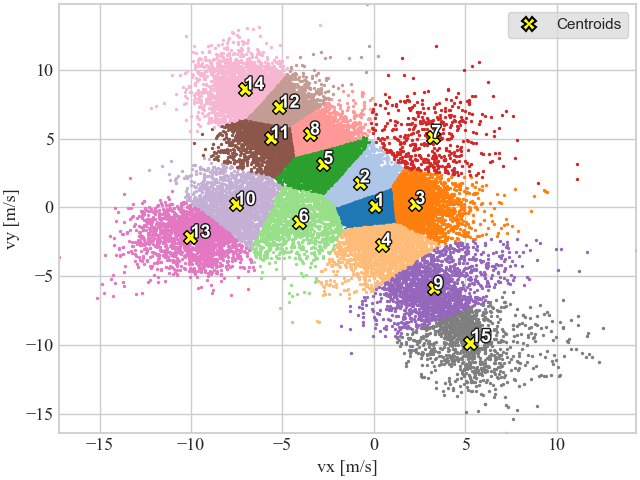

In [13]:
clsclord=('wind',None)
ploti = myfunc.PlotSubClusterInt()
ploti.create_plot(
    clusters_wind.comp_vel,
    figsize=(20, 10),
    idx_centroids=clusters_wind.idx_centroids,
    fign='Figure '+ str(plt.gcf().number+1),
    save_folder='figures_tests/',
    filename = 'plot_clusters_joined',
    showlBetz=False,
    showCent= True,
    showOpt= 'Numero',
    dfMfgCurve=df_mf_curve
                  )

## Agrupamiento de clusters

Se pueden agrupar los clusters en clusters que no produzcan energía, y clusters que produzcan energía. Si suponemos
que la velocidad de cut-in del aerogenerador es de 4 m/s, podemos decir que las velocidades iguales a menores a la
velocidad de cut-in producen 0 Mw y se pueden agrupar en un solo cluster. La probabilidad de ocurrencia de cada
estado se muestra en el siguiente tabla:

In [14]:
#probabilidades de cada estado
dfclvv = myfunc.create_clustered_data(df_wind_dir,clusters_wind.kmeans_labels)

nregcl=[]
for col in dfclvv.columns:
    nregcl.append(len(dfclvv[dfclvv[col].notna()]))
ntotreg= len(df_wind_dir)
df_prob_x_estado = pd.DataFrame(clusters_wind.idx_centroids['mag_windv'].values,columns=['vel'])
df_prob_x_estado.set_index(dfclvv.columns,inplace=True)
df_prob_x_estado.index.name= 'cluster'
df_prob_x_estado['%prob']=np.array(nregcl)/ntotreg *100
df_prob_x_estado

vel    %prob
cluster                 
C1        0.102  24.5343
C2        1.965   9.5721
C3        2.256   6.7810
C4        2.788   4.0431
C5        4.215   9.1783
C6        4.244   2.5781
C7        6.055   0.8809
C8        6.356   9.0831
C9        6.751   3.2345
C10       7.530   6.4480
C11       7.570   3.4552
C12       8.910   8.6950
C13      10.260   3.4171
C14      11.100   6.0979
C15      11.210   2.0016

In [14]:
#df_prob_x_estado.iloc[[0,1,2,3,4]]['%prob'].sum()    -100

 Además, si agrupamos los clusters conjuntos con velocidades de viento similares y porcentajes de ocurrencia
significativos, podemos agrupar los clusters de la siguiente manera:
<ul>
  <li>C1, C2, C3, C4, C5 y C6</li>
  <li>C8 y C9 </li>
  <li>C10 y C11</li>
  <li>C12 y C13</li>
  <li>C14 y C15</li>
</ul>

El cluster C7 se elimina debido a la baja probabilidad de ocurrir.



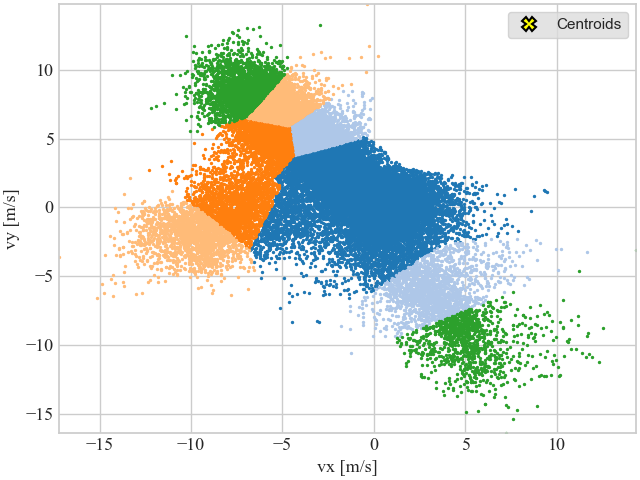

In [15]:
col_to_join = [['C1','C2','C3','C4','C5','C6',],['C8','C9'],['C10','C11'],['C12','C13'],['C14','C15']]
col_to_del = [['C7']]
dfclvv_joined = myfunc.join_clusters(dfclvv.copy(),col_to_join,col_to_del)
df_comp_vel_joined = myfunc.join_clusters(clusters_wind.comp_vel.copy(),col_to_join,col_to_del)
clsclord=('wind',None)
ploti = myfunc.PlotSubClusterInt()
ploti.create_plot(
    df_comp_vel_joined,
    figsize=(20, 10),
    fign='Figure '+ str(plt.gcf().number+1),
    save_folder='figures_tests/',
    filename = 'plot_clusters_joined',
    showlBetz=False,
    showCent= False,
    showOpt= 'Ninguno',
    dfMfgCurve=df_mf_curve
)

Si hacemos una operación de clustering cambiando el número de clusters de 15 a 5 se obtiene la imagen.

C:\Users\mungu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


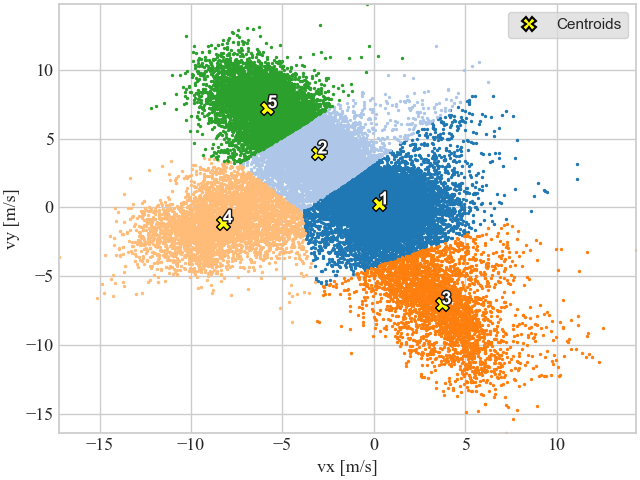

In [20]:
n_clusters = 5
clusters_wind_5 = myfunc.KMData()
clusters_wind_5.dataframe_to_cluster(df_comp_vel, n_clusters=n_clusters, clusters_data='wind')
clsclord=('wind',None)
ploti_5c = myfunc.PlotSubClusterInt()
ploti_5c.create_plot(
    clusters_wind_5.comp_vel,
    figsize=(20, 10),
    idx_centroids=clusters_wind_5.idx_centroids,
    fign='Figure '+ str(plt.gcf().number+1),
    save_folder = 'figures_tests/',
    filename = 'plot5clusters',
    showlBetz=False,
    showCent= True,
    showOpt= 'Numero',
    dfMfgCurve=df_mf_curve
)

En las dos figuras anteriores se comparan los clusters automáticos vs los manuales. La siguiente tabla muestra de
manera cuantitiva la diferencia entre las magnitudes de viento de los clusters calculados manualmente vs los clusters
 calculados automaticamente. 

In [21]:
#comparacion de magnitudes de vv de clusters automaticos vs manuales
prom = []
for c in dfclvv_joined.columns:
    prom.append(dfclvv_joined[c].mean())
df_comp_clust = clusters_wind_5.idx_centroids.copy()
df_comp_clust.reset_index(inplace=True)
cols_to_del =['cluster_ID','vx','vy']
for i in cols_to_del:
    df_comp_clust.drop(i,axis=1,inplace=True )
df_comp_clust.set_index('PCTimeStamp',inplace=True)
df_comp_clust.columns=['cl_auto','mag_auto']
df_comp_clust.cl_auto=df_comp_clust.cl_auto.apply(lambda c:'C'+str(c))
df_comp_clust['cl_manual'] = dfclvv_joined.columns
df_comp_clust['mag_manual'] = prom
df_comp_clust

cl_auto  mag_auto cl_manual  mag_manual
PCTimeStamp                                                
2005-01-02 11:10:00      C1     0.347        C1      1.9819
2005-06-17 11:20:00      C2     4.985        C8      6.5469
2005-03-13 19:00:00      C3     7.980       C10      7.6259
2005-08-15 09:20:00      C4     8.320       C12      9.3307
2005-01-18 21:00:00      C5     9.280       C14     11.1891

In [23]:
clusters_wind_5

cluster_ID         PCTimeStamp      vx      vy  mag_windv
cluster_ID_ord                                                           
1                        0 2005-01-02 11:10:00  0.2701  0.2179      0.347
2                        2 2005-06-17 11:20:00 -3.0739  3.9245      4.985
3                        3 2005-03-13 19:00:00  3.7094 -7.0654      7.980
4                        4 2005-08-15 09:20:00 -8.2410 -1.1435      8.320
5                        1 2005-01-18 21:00:00 -5.8288  7.2211      9.280

# Estudio de impacto ambiental (Proyecto San Carlos)

["MIA Eolico San Carlos.pdf"](file:///MIA.pdf)


## Resumen

Para el proyecto eólico San Carlos se hizo un estudio de impacto ambiental (hecho por otras personas,ver pdf) con un
análisis de viento que se
obtuvo a
partir de una torre de sensores instalada en el sitio. Las observaciones abarcan de octubre de 2005 a septiembre de
2006, a 30, 40, 50 y 60 m de altura y a intervalos de 10 min. La mediana[sic?] del viento, a 60 m de altura, es de 4
.8 m/s (17.3 km/h), en abril se presentan los vientos de mayor intensidad, de 6.2 m/s (22 km/h), y en diciembre se
presentan los vientos de mayor intensidad, de 6.2 m/s (22 km/h), y en diciembre se presentan los de menor intensidad
3.9 m/s (14 km/h). Los vientos de mayor magnitud se observan en julio y septiembre, alcanzando los 20 m/s (72 km/h) y
 18 m/s (64.8 km/h) respectivamente. Estos valores extremos se encuentran relacionados con el paso de los huracanes
 "Lane" y "Jon" respectivamente.

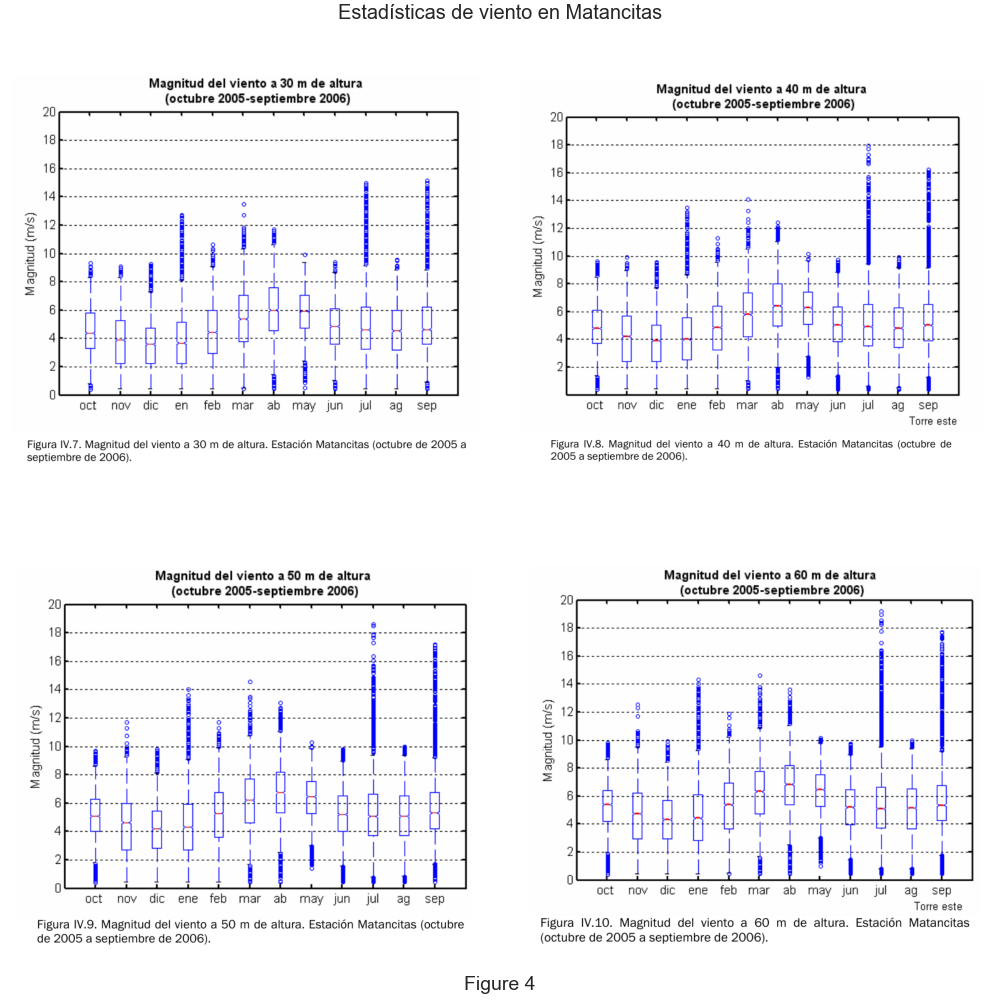

In [18]:
fig, axs = plt.subplots(2, 2,figsize=(10,10),constrained_layout=True)
imv30 = plt.imread('figuras/magnitud_viento_30m_matancitas.png')
imv40 = plt.imread('figuras/magnitud_viento_40m_matancitas.png')
imv50 = plt.imread('figuras/magnitud_viento_50m_matancitas.png')
imv60 = plt.imread('figuras/magnitud_viento_60m_matancitas.png')
axs[0,0].axis('off')
axs[1,1].axis('off')
axs[1,0].axis('off')
axs[0,1].axis('off')
axs[0,0].imshow(imv30)
axs[0,1].imshow(imv40)
axs[1,0].imshow(imv50)
axs[1,1].imshow(imv60)
plt.suptitle('Estadísticas de viento en Matancitas')
plt.figtext(0.5, 0.01, 'Figure '+ str(plt.gcf().number), wrap=True, horizontalalignment='center', fontsize=14)
plt.show()

La Figure 6 muestra la magnitud y dirección de los vientos a 50 m de altura, observándose que pedominan los vientos
del sureste.

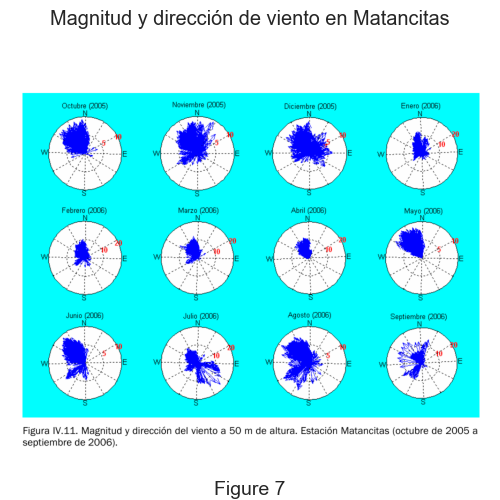

In [19]:
plt.figure(7, figsize=(5,5))
imvd50 = plt.imread('figuras/magnitud_viento_dir_50m_matancitas.png')
plt.axis('off')
plt.imshow(imvd50)
plt.suptitle('Magnitud y dirección de viento en Matancitas')
plt.figtext(0.5, 0.01, 'Figure '+ str(plt.gcf().number), wrap=True, horizontalalignment='center', fontsize=14)
plt.tight_layout()
plt.show()

## Análisis de los datos de viento de 2005

Los siguientes resultados se obtienen analizando los datos de viento del año 2005 que tenemos (ubicación del lugar
de tomas de muestradesconocida).

In [20]:
prom = df_wind_dir.vwind.mean()
abril = df_wind_dir[df_wind_dir.index.month==4].vwind.mean()
diciembre = df_wind_dir[df_wind_dir.index.month==12].vwind.mean()
print('Velocidad promedio anual: %0.2f\nVelocidad promedio abril: %0.2f\n'
      'Velocidad promedio diciembre: %0.2f' %(prom,abril,diciembre))



Velocidad promedio anual: 4.78
Velocidad promedio abril: 4.62
Velocidad promedio diciembre: 3.66


## Box plot de los datos de viento de 2005

In [21]:
# #https://onlinelibrary.wiley.com/doi/pdf/10.1016/j.pmrj.2016.02.001
# #https://www.uaq.mx/statsoft/glose.html
#
# #obtener mediana de cada mes
# medianas = \
#     [np.round(df_wind_dir.loc[df_wind_dir.index.month==m].vwind.median(),1) for m in range(1,13)]
# # percentile 25
# perc25 =\
#     [np.round(df_wind_dir.loc[df_wind_dir.index.month==m].vwind.quantile(q=0.25),1) for m in range(1,13)]
# #percentile 75
# perc75 = \
#     [np.round(df_wind_dir.loc[df_wind_dir.index.month==m].vwind.quantile(q=0.75),1) for m in range(1,13)]
# #obtener datos de los percentiles
# #dividir el dataframe en meses
# data_mes =[np.round(df_wind_dir.loc[df_wind_dir.index.month==m],1) for m in range(1,13)]
# #obtener los datos mayores al percentil 25
# data_p25 = [data_mes[m].loc[data_mes[m].vwind<perc25[m]] for m in range(12)]
# #obtener los datos mayores al percentil 75
# data_p75 = [data_mes[m].loc[data_mes[m].vwind>perc75[m]] for m in range(12)]
# # valores extremos 1.5 de la longitud de la caja (interquarltile range)
# #extremo percentil 25
# data_p25_ext = [data_mes[m].loc[data_mes[m].vwind<perc25[m]*1.5] for m in range(12)]
# #extremo percentil 75
# data_p75_ext = [data_mes[m].loc[data_mes[m].vwind>perc75[m]*1.5] for m in range(12)]
# #los bigotes (whiskers) son el lower extreme y el upper extreme
# lower_extreme = [data_p25_ext[m].vwind.min() for m in range(12)]
# upper_extreme = [data_p75_ext[m].vwind.min() for m in range(12)]

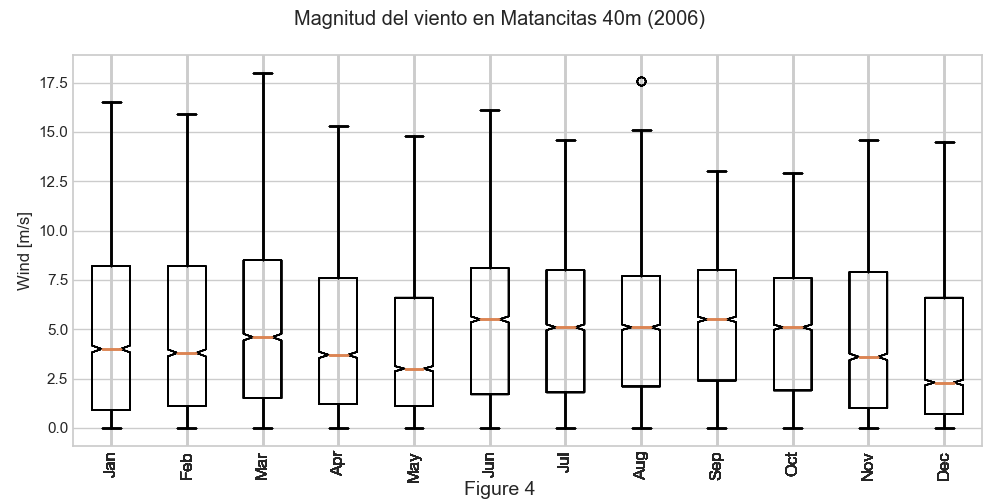

In [22]:
#dividir el dataframe en meses
data_mes =[np.round(df_wind_dir.loc[df_wind_dir.index.month==m],1) for m in range(1,13)]
#obtener nombres de los meses
nomb_meses = [datetime.strptime(str(m), "%m").strftime("%b") for m in range(1, 13)]
plt.figure(figsize=(10,5))
data_mes_dividida = [data_mes[m].vwind.values for m in range(12)]
for m in range(12):
    plt.boxplot(data_mes_dividida,notch=True,labels=nomb_meses,meanline=True)
plt.xticks(fontsize=12, rotation=90)
plt.suptitle('Magnitud del viento en Matancitas 40m (2006)')
plt.figtext(0.5, 0.01, 'Figure '+ str(plt.gcf().number), wrap=True, horizontalalignment='center', fontsize=14)
plt.ylabel('Wind [m/s]')
plt.tight_layout()
plt.show()

## Plot de direcciones de viento

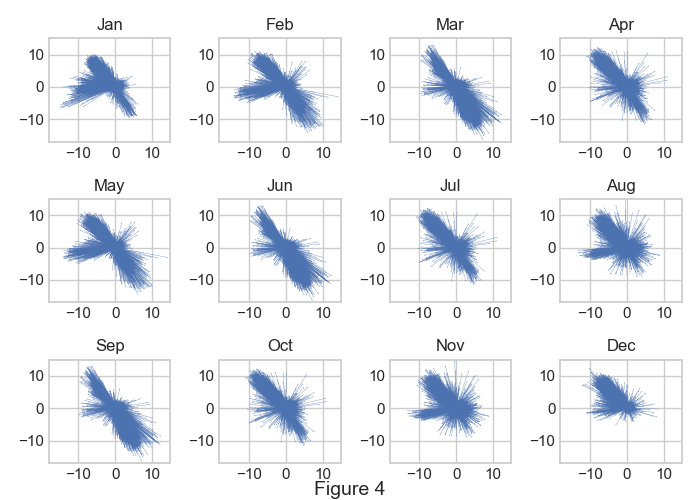

In [23]:
f =myfunc.plot_vectors(df_comp_vel,fign=plt.gcf().number+1,show_month=0)



En los gráficos anteriores se observan similitudes con los datos mostrados en el reporte, pero aún así no se puede
asegurar que los datos de viento de 2005 son de matancitas.

## Curva de potencia del fabricante

Segun el reporte de San Carlos se utiliza una turbina eólica Dewind d8.2. Las carácteristicas de la curba de potencia
de esta turbina se ajustan bien a los datos de viento que tenemos, por lo que es la que se usa en el analisis de
potencias.

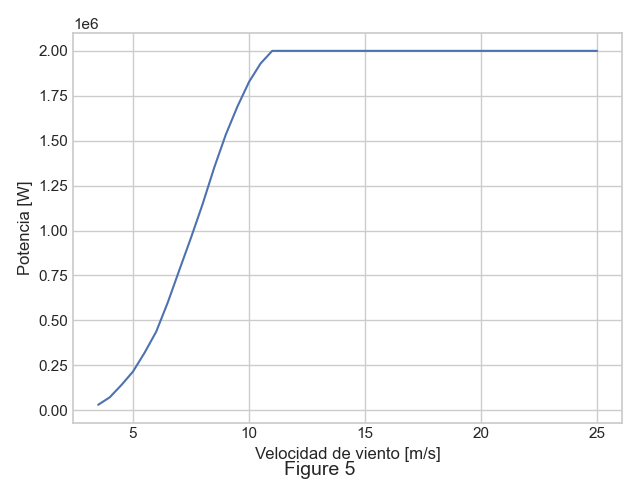

In [24]:
#https://www.thewindpower.net/turbine_es_575_dewind_d8.2.php
#http://windatlas.xyz/turbine/?name=Dewind%20D8.2
plt.figure(plt.gcf().number+2)
plt.plot(df_mf_curve.index,df_mf_curve.pw)
plt.xlabel('Velocidad de viento [m/s]')
plt.ylabel('Potencia [W]')
plt.figtext(0.5, 0.01, 'Figure '+ str(plt.gcf().number), wrap=True, horizontalalignment='center', fontsize=14)
plt.tight_layout()
plt.show()

# Markov

## Step plot

 En el step plot se observan los cambios de estados a lo largo del tiempo.

In [25]:
#convetir matriz de estados a vector de estados (o transiciones)
#este vector debe ser igual a kmeans_labels  cuando no se ha modificado el df
vect_states = myfunc.mat_to_vector(dfclvv)
#primera fecha de registro de datos
first_date= df_wind_dir.index[0]
last_date =  df_wind_dir.index[-1]
wdg_stateplot_datepicker =widgets.DatePicker(description='(mm/dd/YYYY:', disabled=False, start=first_date )
wdg_stateplot_datepicker.value=first_date
wdg_stateplot_actbutton = widgets.Button(description='Actualizar')
display(wdg_stateplot_datepicker)
display(wdg_stateplot_actbutton)

def on_button_stateplot_clicked(b):
    """
    Crea un stepplot de acuerdo a la fecha seleccionada
    :param b:
    """

    mask_month = df_wind_dir.index.month ==wdg_stateplot_datepicker.value.month
    mask_day =  df_wind_dir.index.day ==wdg_stateplot_datepicker.value.day
    data = df_wind_dir.loc[mask_month & mask_day ]
    fig, ax = plt.subplots(figsize=(15,5))

    ax.step(data.index,clusters_wind.kmeans_labels[:len(data)],where='post')
    hours = mdates.MinuteLocator(interval=30)
    h_fmt = mdates.DateFormatter('%H:%M')
    ax.xaxis.set_major_locator(hours)
    ax.xaxis.set_major_formatter(h_fmt)
    plt.xticks(rotation = 90)
    ax.set_xticks(pd.date_range(start=wdg_stateplot_datepicker.value, end=wdg_stateplot_datepicker.value+pd.to_timedelta('1D'),
                                freq='30min'))
    plt.suptitle(str(wdg_stateplot_datepicker.value.strftime('%Y-%m-%d')))
    plt.tight_layout()
    plt.xlabel('Hora del día')
    plt.ylabel('Estado')
    plt.show()

wdg_stateplot_actbutton.on_click(on_button_stateplot_clicked)



DatePicker(value=Timestamp('2005-01-01 00:10:00'), description='(mm/dd/YYYY:')

Button(description='Actualizar', style=ButtonStyle())

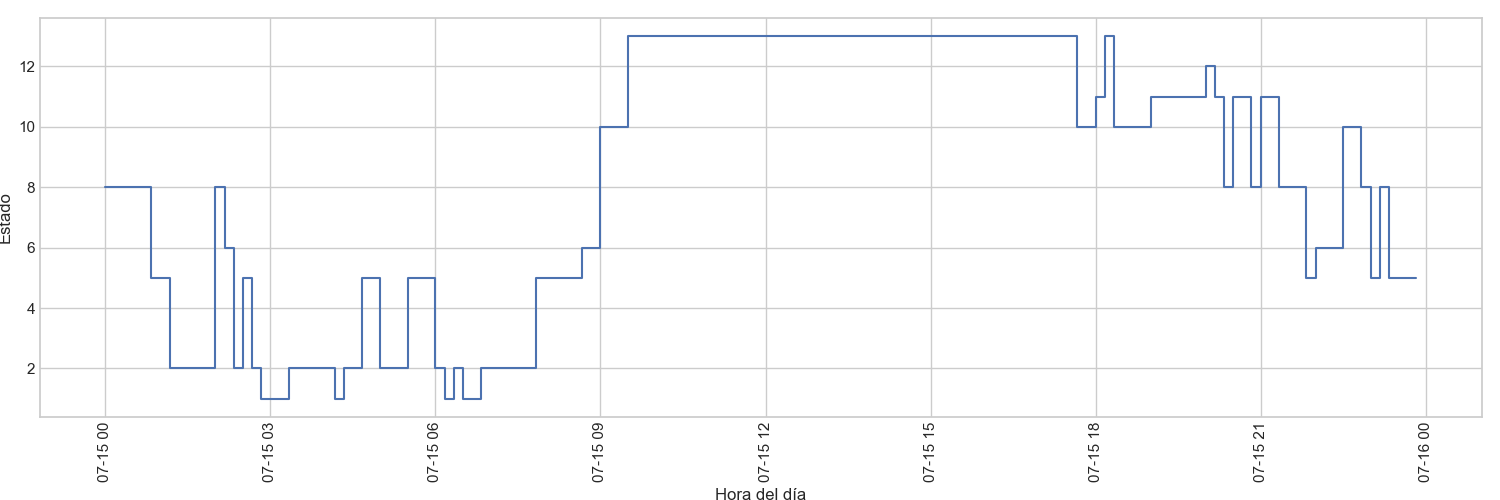

In [36]:
mask_month = df_wind_dir.index.month ==wdg_stateplot_datepicker.value.month
mask_day =  df_wind_dir.index.day ==wdg_stateplot_datepicker.value.day
mask_month = df_wind_dir.index.month ==pd.to_datetime('2005/07/15').month
mask_day =  df_wind_dir.index.day ==pd.to_datetime('2005/07/15').day
data = df_wind_dir_cl.loc[mask_month & mask_day  ]
lcluster =df_wind_dir_cl.loc[mask_month & mask_day ].cluster.apply(lambda x:int(x[1:]))

fig, ax = plt.subplots(figsize=(15,5))

#ax.step(data.index,clusters_wind.kmeans_labels[:len(data)],where='post')
ax.step(data.index,lcluster,where='post')

# hours = mdates.MinuteLocator(interval=30)
# h_fmt = mdates.DateFormatter('%H:%M')
# ax.xaxis.set_major_locator(hours)
# ax.xaxis.set_major_formatter(h_fmt)
plt.xticks(rotation = 90)
#ax.set_xticks(pd.date_range(start=pd.to_datetime('2005/06/01'), end=pd.to_datetime('2005/06/01')+pd.to_timedelta('1M'),
                           # freq='30min'))
#plt.suptitle(str(wdg_stateplot_datepicker.value.strftime('%Y-%m-%d')))
plt.tight_layout()
plt.xlabel('Hora del día')
plt.ylabel('Estado')
plt.show()




## Matriz de transición de probabilidades

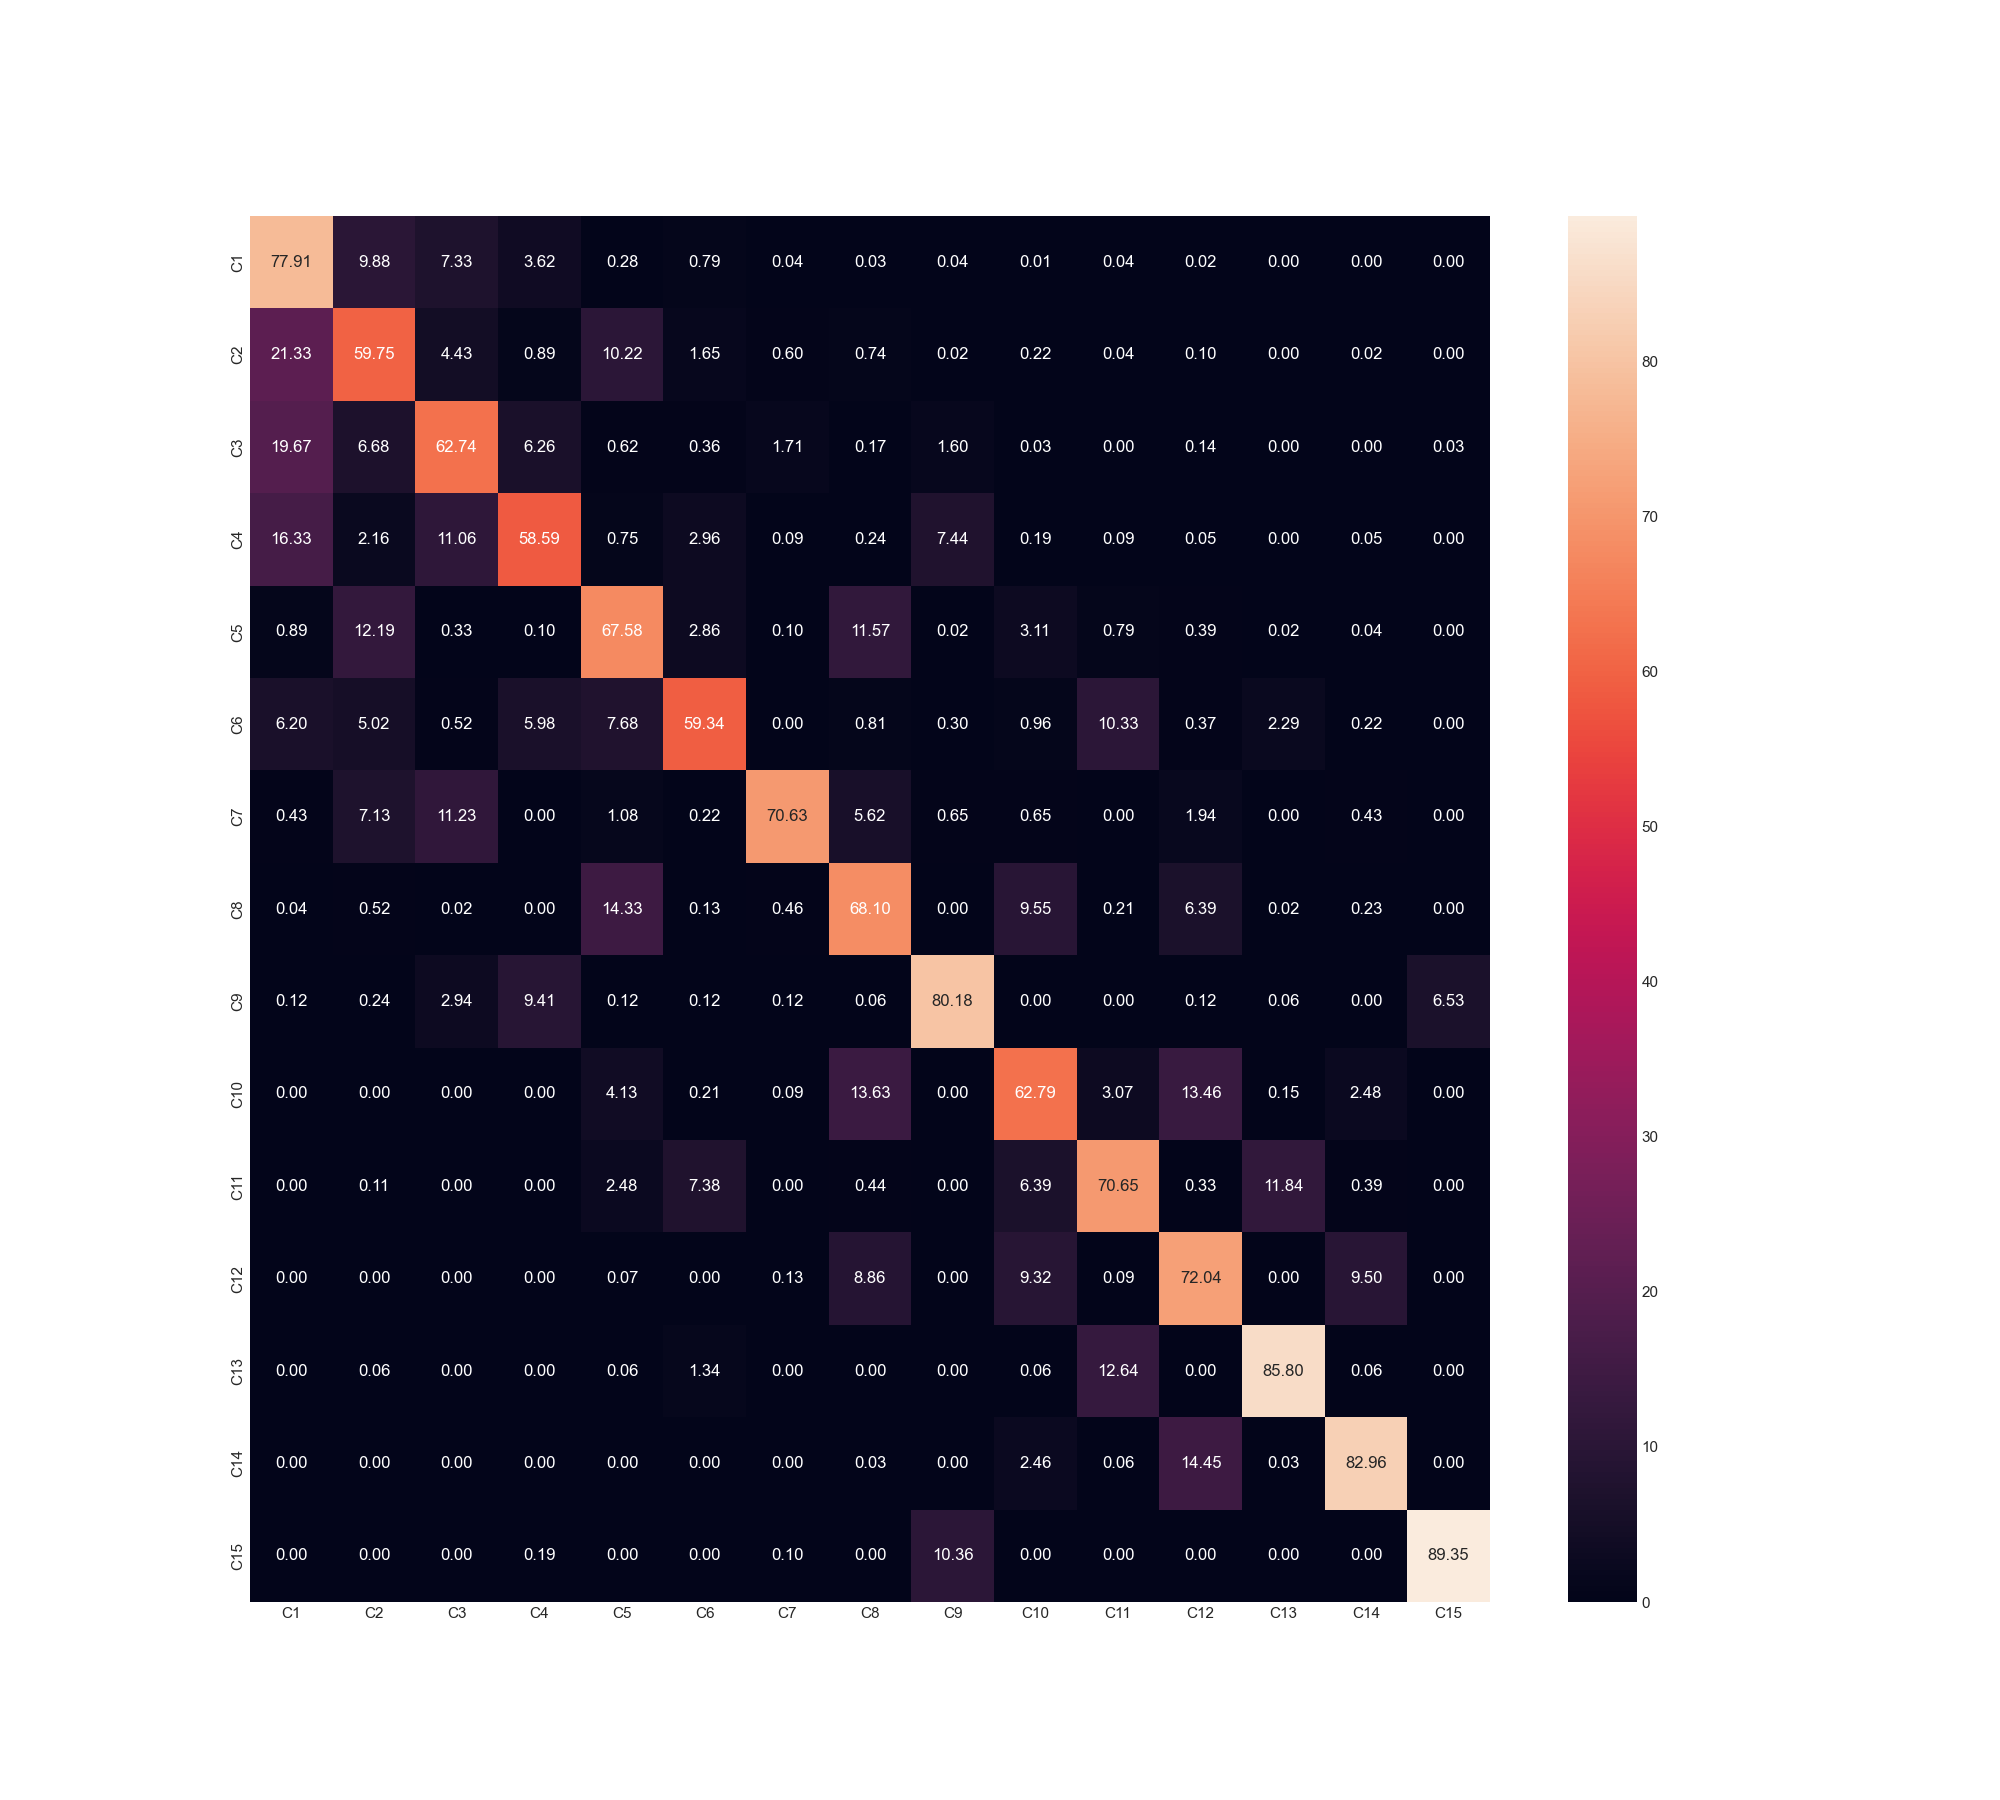

In [27]:
dfclvv = myfunc.create_clustered_data(df_wind_dir,clusters_wind.kmeans_labels)
mat_trans_prob= myfunc.trans_matrix_from_df(dfclvv,mat_mode='prob')
#SOLO FUNCIONA PARA FILAS PERO NO PARA COLUMNAS
plt.figure(figsize=(20,18))

ht =sns.heatmap(mat_trans_prob, annot=True,fmt='.2f')
figure = ht.get_figure()
plt.show()


# Cadena de Markov para valores de prob. mayor a 10%

In [28]:
#eliminar valores menores a 10%
matprob10p = mat_trans_prob.mask(mat_trans_prob<10)
#conviertiendo nan a cero
#matprob10p.fillna(0,inplace=True)
#matprob10p = np.round(matprob10p,4)

#myfunc.create_mc_plot(21,matprob10p.copy(), as_pct=True, replace_zero_to_nan=True, layout='circle');


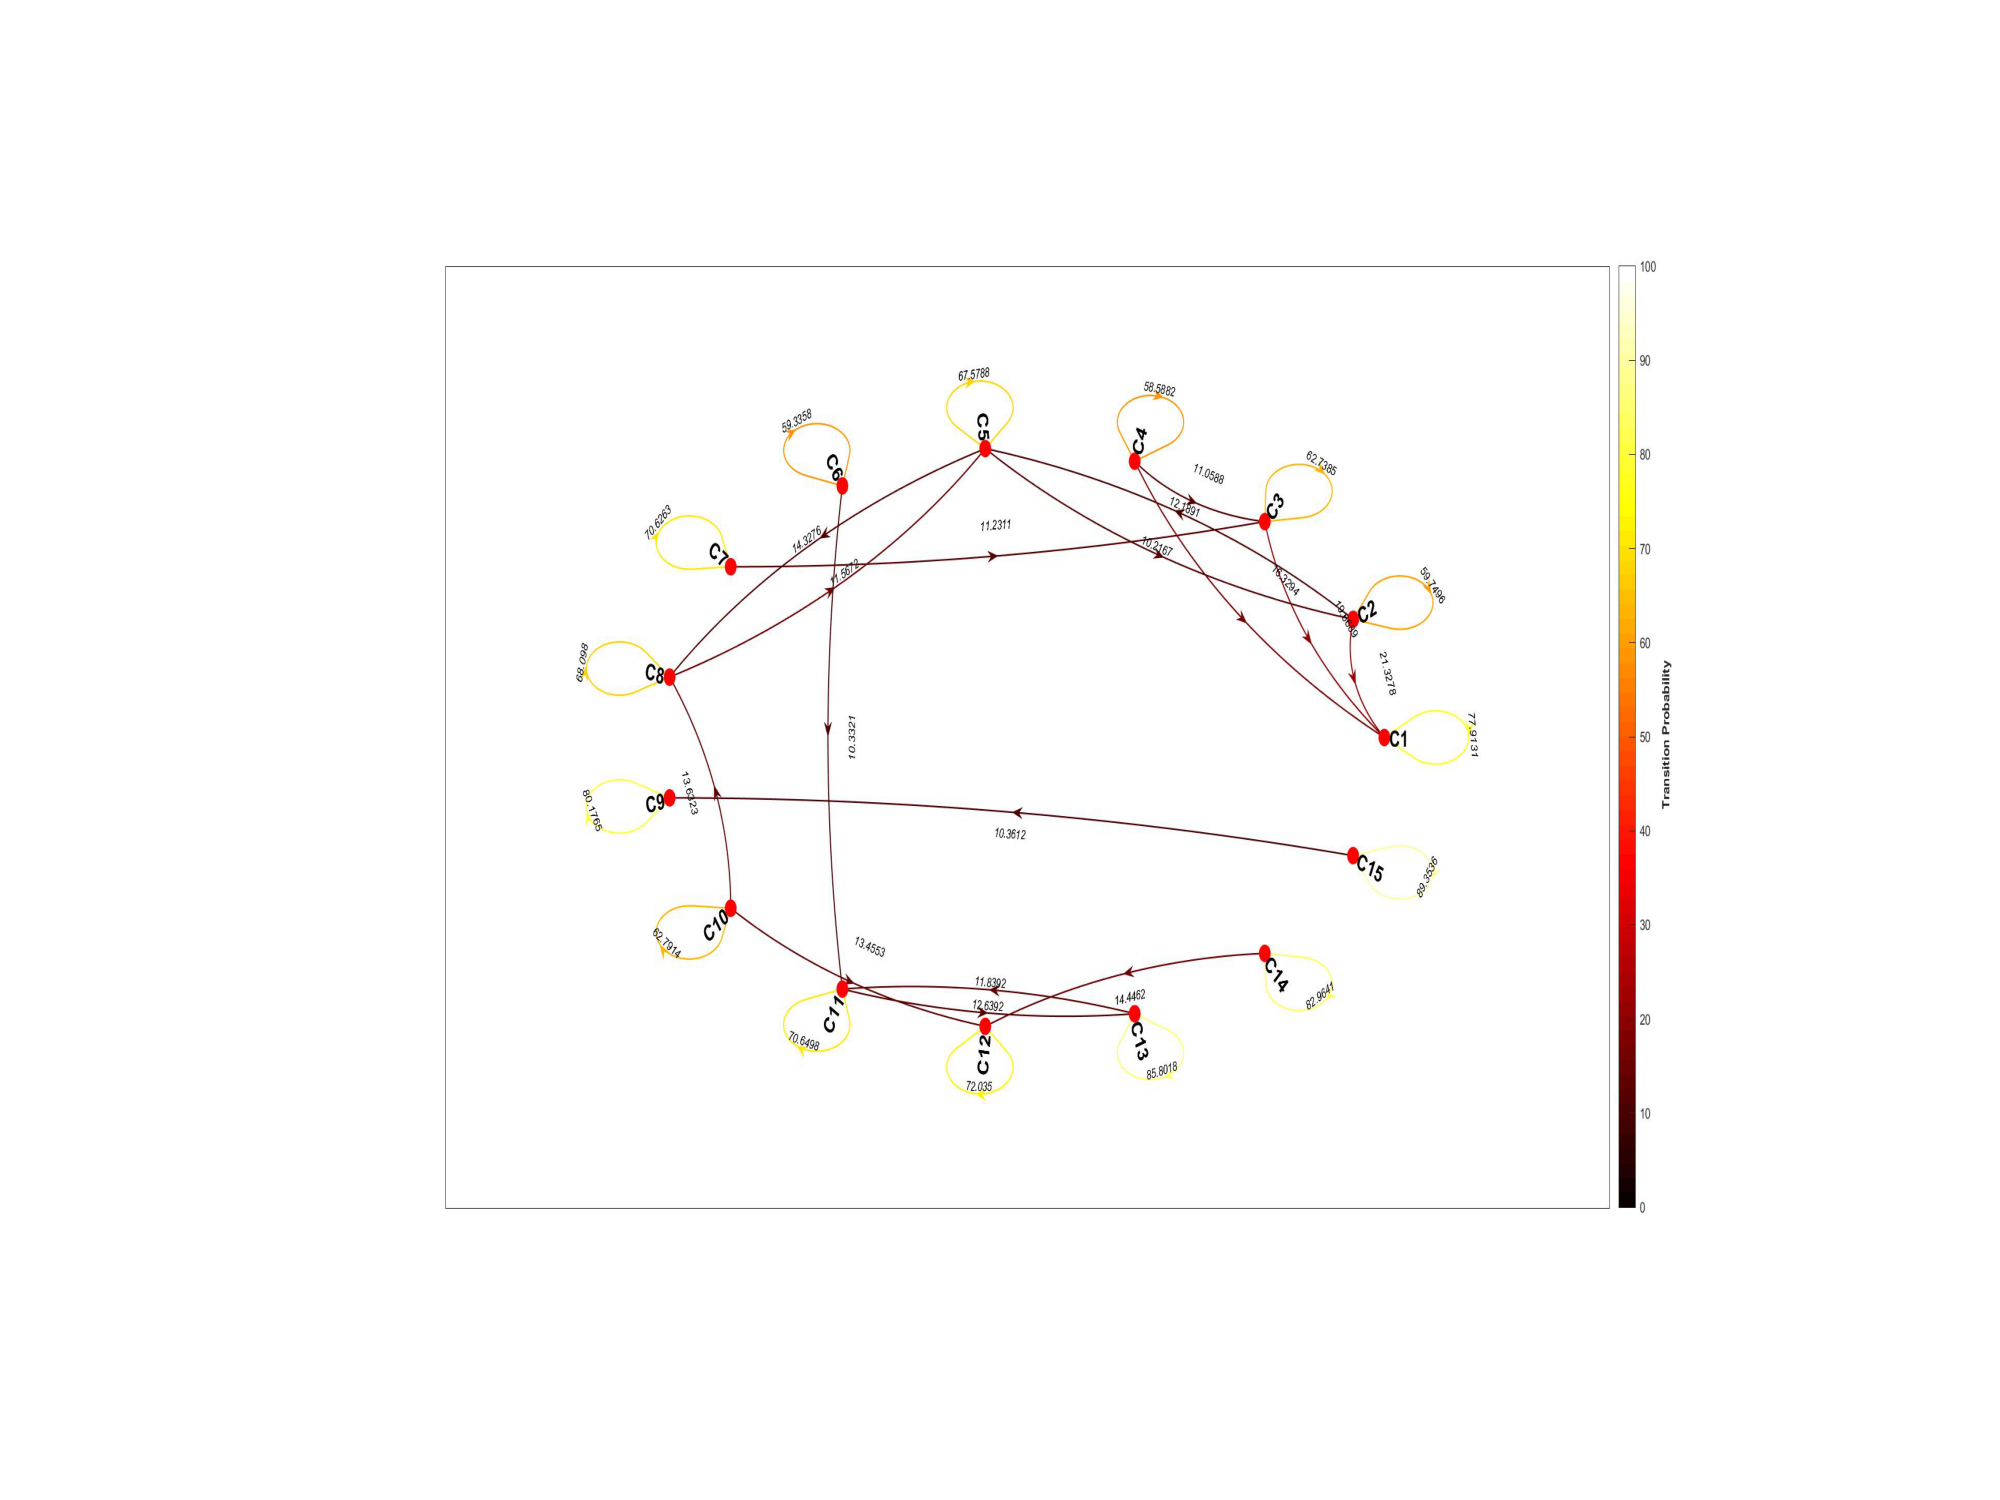

In [29]:
img = image.imread('graph_mc_bk.jpg')
plt.figure(figsize=(20,15))
plt.imshow(img,aspect='auto')
plt.grid(False)
plt.axis('off')
plt.show()

## Matriz de transición de probabilidad con clusters agrupados

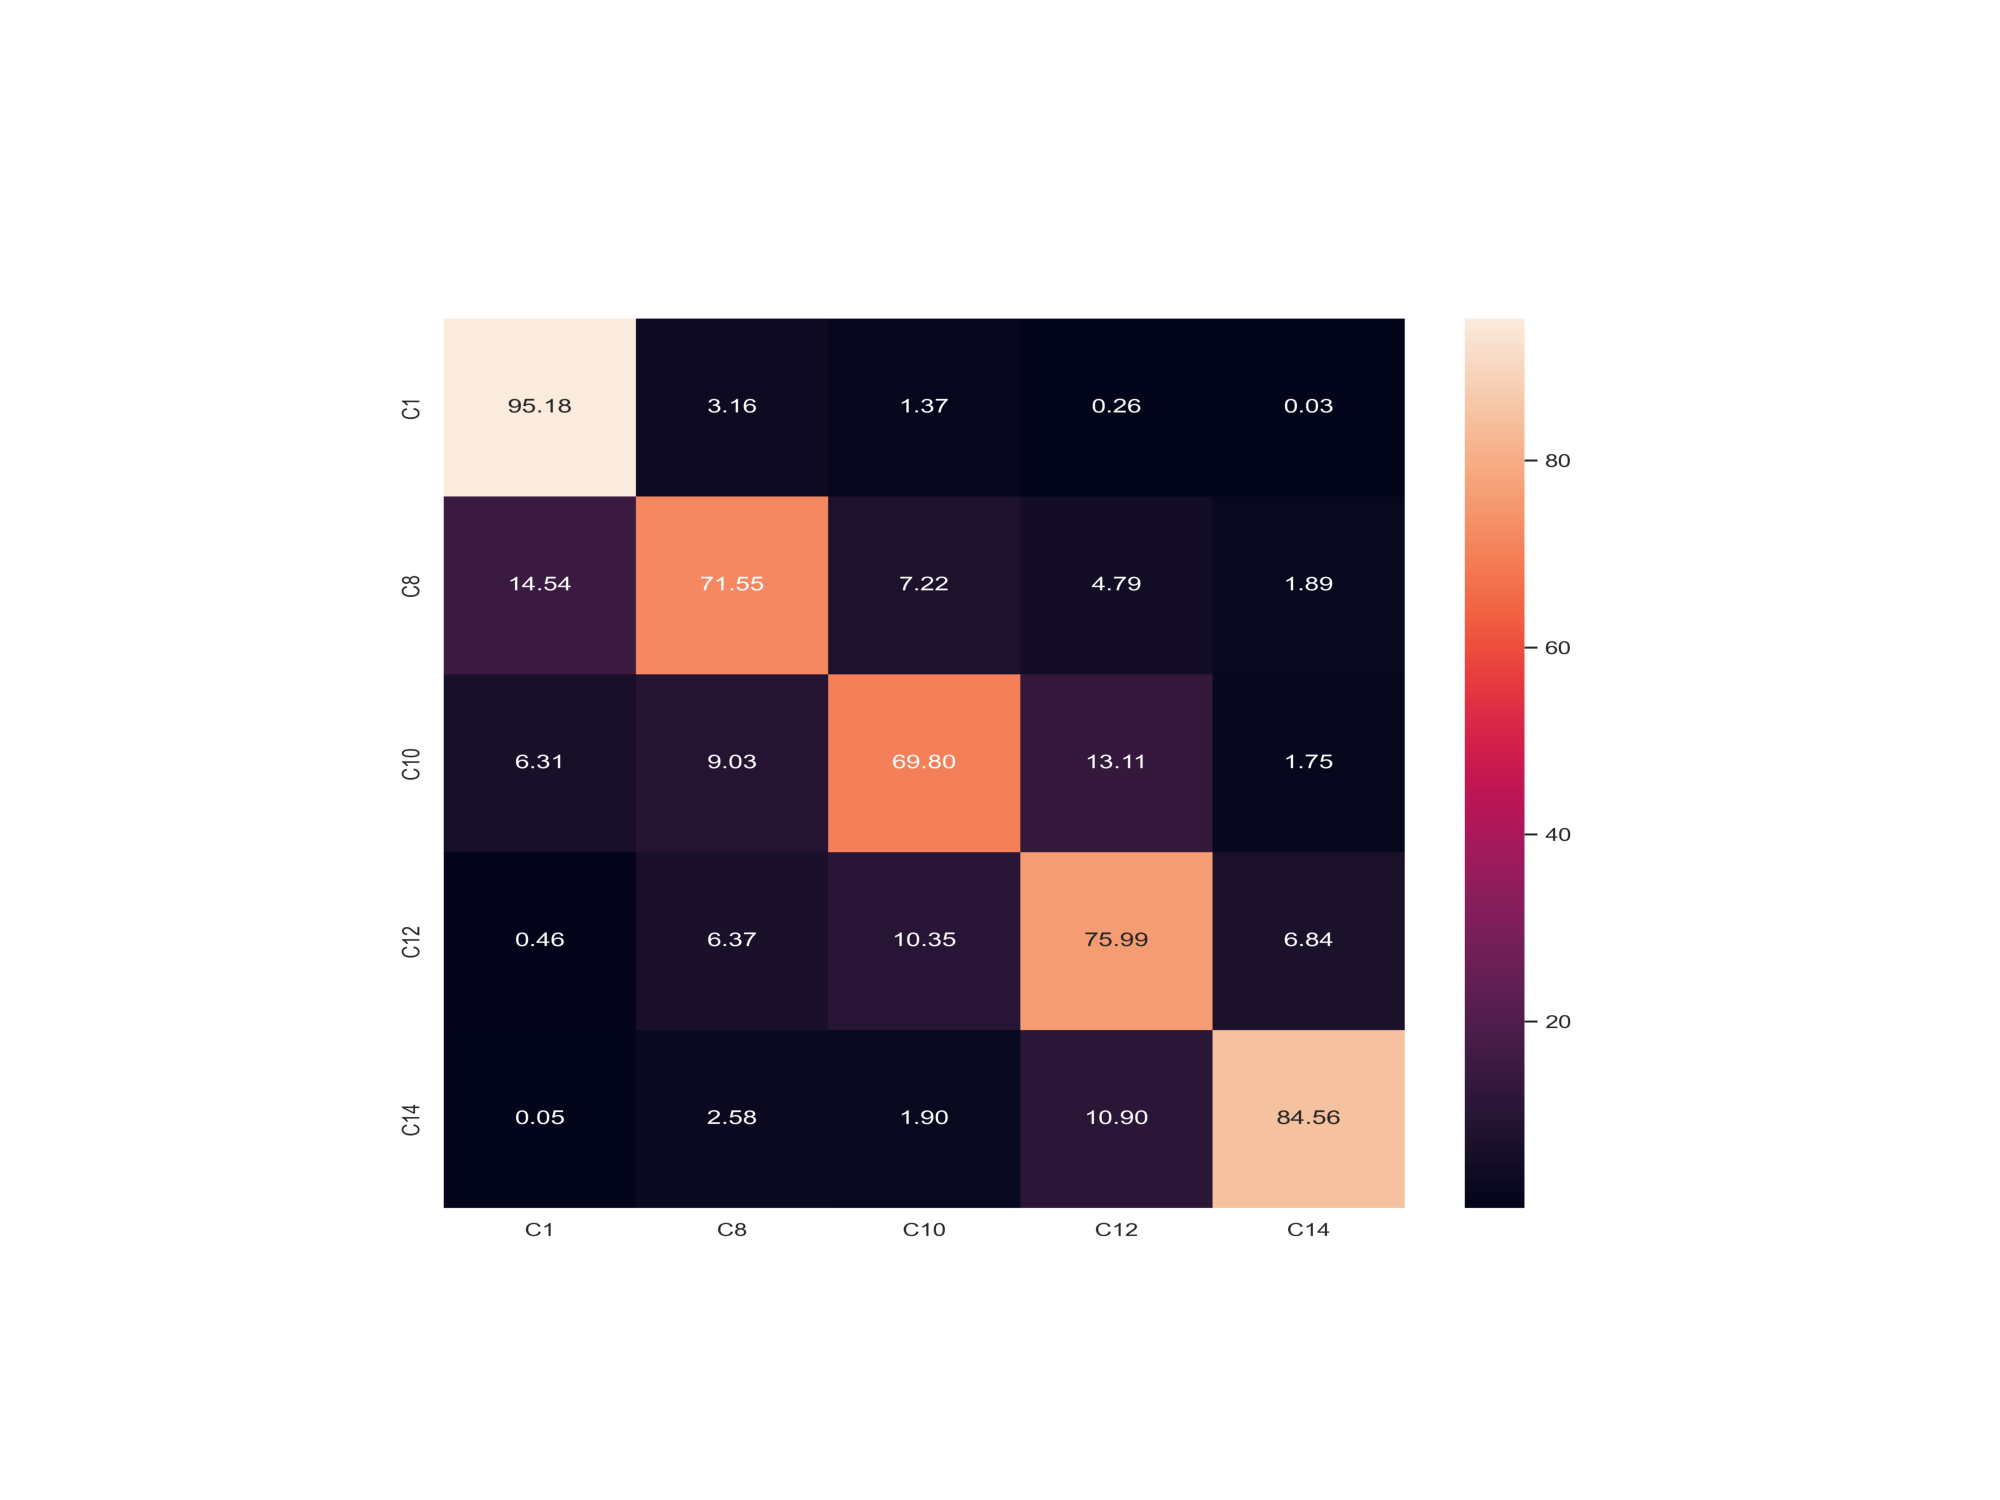

In [30]:
img = image.imread('ht_prob_joined_bk.png')
plt.figure(figsize=(20,15))
plt.imshow(img,aspect='auto')
plt.grid(False)
plt.axis('off')
plt.show()

## Cadena de Markov de clusters agrupados

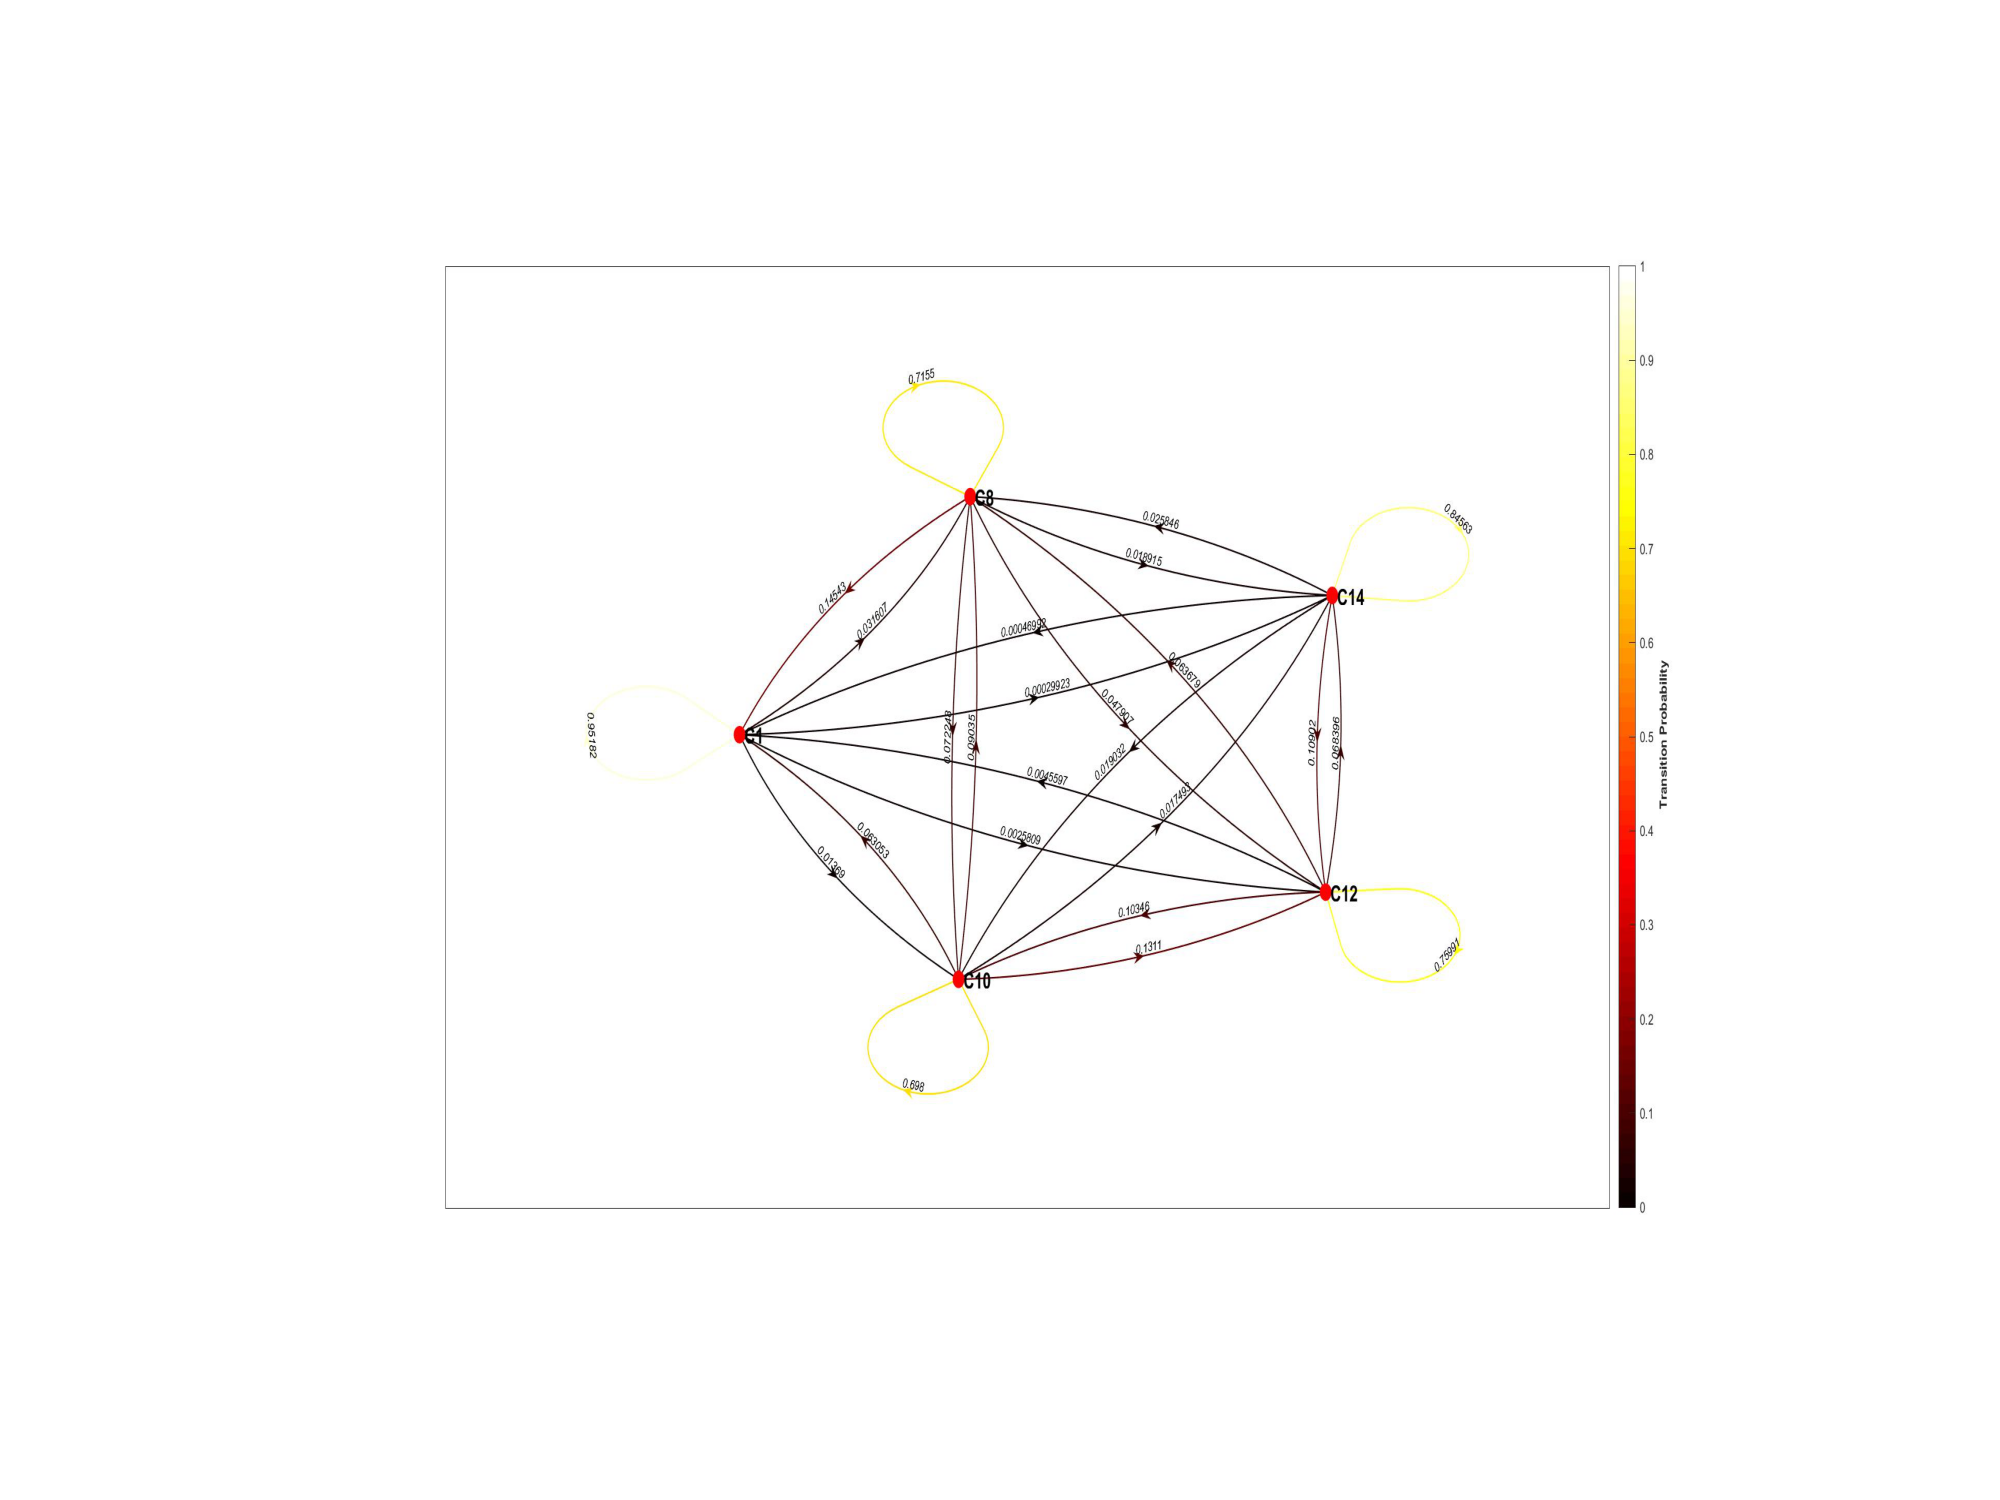

In [32]:
img = image.imread('graph_mc_joined.jpg')
plt.figure(figsize=(20,15))
plt.imshow(img,aspect='auto')
plt.grid(False)
plt.axis('off')
plt.show()

In [ ]:
# lcluster =df_wind_dir_cl.cluster.apply(lambda x:str(x[1:])).values

In [ ]:
# fig, ax = plt.subplots(figsize=(15,5))
#
# ax.step(data.index,clusters_wind.kmeans_labels[:len(data)],where='post')
# hours = mdates.MinuteLocator(interval=30)
# h_fmt = mdates.DateFormatter('%H:%M')
# ax.xaxis.set_major_locator(hours)
# ax.xaxis.set_major_formatter(h_fmt)
# plt.xticks(rotation = 90)
# ax.set_xticks(pd.date_range(start=wdg_stateplot_datepicker.value, end=wdg_stateplot_datepicker.value+pd.to_timedelta('1D'),
#                             freq='30min'))
# plt.suptitle(str(wdg_stateplot_datepicker.value.strftime('%Y-%m-%d')))
# plt.tight_layout()
# plt.xlabel('Hora del día')
# plt.ylabel('Estado')
# plt.show()


# Estacionalidad

In [ ]:
df = df_wind_dir_cl.copy()
#estaciones meteoroligicas (no astronomicas)
primavera_inicio = pd.to_datetime('1-03-2005',format='%d-%m-%Y')
verano_inicio = pd.to_datetime('1-06-2005',format='%d-%m-%Y')
otonio_inicio = pd.to_datetime('1-09-2005',format='%d-%m-%Y')
invierno_inicio = pd.to_datetime('1-12-2005',format='%d-%m-%Y')

maskPrim = ( (df.index >=primavera_inicio ) &(df.index <verano_inicio ))
dfwd_prim = df.loc[maskPrim]

maskVer = ( (df.index >=verano_inicio  ) &(df.index <otonio_inicio ))
dfwd_ver = df.loc[maskVer]

maskOtonio= ( (df.index >=otonio_inicio ) &(df.index <invierno_inicio ))
dfwd_otonio = df.loc[maskOtonio]

maskInv = ( (df.index < primavera_inicio) | (df.index >=invierno_inicio ))

dfwd_inv = df.loc[maskInv]


## Primavera

In [ ]:
gp_prim =dfwd_prim.groupby("cluster").count()
gp_prim['pct']=gp_prim.wdir.values/(len(dfwd_prim)) *100
gp_prim.drop('wdir',axis=1,inplace=True)
gp_prim.sort_values(by='pct',ascending=False)


In [ ]:
plt.figure()
plt.suptitle('% por cluster en primavera ')
explode= (0,0,0,0,0)
wedges, texts, autotexts = plt.pie(gp_prim.pct, autopct='%1.2f%%', textprops=dict(color="w"),
                                   shadow=False, startangle=0)
plt.gca().axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.legend(labels = gp_prim.index)

plt.show()

## Verano

In [ ]:
gp_ver =dfwd_ver.groupby("cluster").count()
gp_ver['pct']=gp_ver.wdir.values/(len(dfwd_ver)) *100
gp_ver.drop('wdir',axis=1,inplace=True)
gp_ver.sort_values(by='pct',ascending=False)

In [ ]:
plt.figure()

explode= (0,0,0,0,0)
wedges, texts, autotexts = plt.pie(gp_ver.pct, autopct='%1.2f%%', textprops=dict(color="w"),
                                   shadow=False, startangle=0)
plt.gca().axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.legend(labels = gp_ver.index)
plt.suptitle('% por cluster en Verano ')
plt.show()

## Otonio

In [ ]:
gp_oto =dfwd_otonio.groupby("cluster").count()
gp_oto['pct']=gp_oto.wdir.values/(len(dfwd_otonio)) *100
gp_oto.drop('wdir',axis=1,inplace=True)
gp_oto.sort_values(by='pct',ascending=False)

In [ ]:
plt.figure()

explode= (0,0,0,0,0)
wedges, texts, autotexts = plt.pie(gp_oto.pct, autopct='%1.2f%%', textprops=dict(color="w"),
                                   shadow=False, startangle=0)
plt.gca().axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.legend(labels = gp_oto.index)
plt.suptitle('% por cluster en otoño ')

plt.show()

## Invierno

In [ ]:
gp_inv =dfwd_inv.groupby("cluster").count()
gp_inv['pct']=gp_inv.wdir.values/(len(dfwd_inv)) *100
gp_inv.drop('wdir',axis=1,inplace=True)
gp_inv.sort_values(by='pct',ascending=False)

In [ ]:
plt.figure()

explode= (0,0,0,0,0)
wedges, texts, autotexts = plt.pie(gp_inv.pct, autopct='%1.2f%%', textprops=dict(color="w"),
                                   shadow=False, startangle=0)
plt.gca().axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.legend(labels = gp_inv.index)
plt.suptitle('% por cluster en invierno')
plt.show()

In [ ]:
#idx = df_wind_dir.loc[(df_wind_dir.index.hour==0)  & (df_wind_dir.index.minute==0)].index
#df_wind_dir.loc[idx].index = df_wind_dir.loc[idx].index + pd.to_timedelta(1,'d')